In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [17]:
# Define file paths relative to the project root
raw_data_path = '../data/raw/S5P_AQI_Data_Delhi_NCR_2020_Present_NRTI.csv'
processed_data_path = '../data/processed/S5P_NRTI_Filled.csv'

In [18]:
# Load the raw satellite data
try:
    s5p_df = pd.read_csv(raw_data_path)
    print("Raw S5P data loaded successfully.")
    print(f"Shape: {s5p_df.shape}")
except FileNotFoundError:
    print(f"Error: Raw data file not found at {raw_data_path}")
    # Stop execution if file not found
    raise

Raw S5P data loaded successfully.
Shape: (16153, 7)


In [19]:
print("\n--- Basic Info ---")
s5p_df.info()


--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16153 entries, 0 to 16152
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           16153 non-null  object 
 1   NO2            7656 non-null   float64
 2   SO2            7708 non-null   float64
 3   CO             7449 non-null   float64
 4   O3             10806 non-null  float64
 5   Aerosol_Index  10994 non-null  float64
 6   location       16153 non-null  object 
dtypes: float64(5), object(2)
memory usage: 883.5+ KB


In [20]:
print("\n--- First 5 Rows ---")
print(s5p_df.head())


--- First 5 Rows ---
         date       NO2       SO2        CO        O3  Aerosol_Index  \
0  01-01-2020       NaN       NaN       NaN       NaN            NaN   
1  02-01-2020  0.000191 -0.000433  0.048550  0.164568      -1.098919   
2  03-01-2020  0.000143  0.000546  0.041712  0.139937      -1.405038   
3  04-01-2020       NaN -0.000315  0.044633  0.137429      -1.210190   
4  05-01-2020  0.000143 -0.000531  0.045669  0.128115      -0.864201   

             location  
0  Anand Vihar, Delhi  
1  Anand Vihar, Delhi  
2  Anand Vihar, Delhi  
3  Anand Vihar, Delhi  
4  Anand Vihar, Delhi  


In [21]:
print("\n--- Summary Statistics ---")
# Describe only numeric columns, handling potential non-numeric parsing issues
print(s5p_df.describe(include=[np.number]))


--- Summary Statistics ---
               NO2          SO2           CO            O3  Aerosol_Index
count  7656.000000  7708.000000  7449.000000  10806.000000   10994.000000
mean      0.000146     0.000145     0.041423      0.126898      -0.247853
std       0.000114     0.000588     0.007013      0.006808       0.964272
min       0.000015    -0.000998     0.023917      0.105325      -5.423089
25%       0.000083    -0.000198     0.036805      0.122542      -0.970623
50%       0.000115     0.000074     0.039930      0.126296      -0.299222
75%       0.000168     0.000398     0.044738      0.130914       0.372394
max       0.001703     0.006777     0.087687      0.166354       4.218647


In [22]:
print("\n--- Check Unique Locations ---")
print(s5p_df['location'].unique())


--- Check Unique Locations ---
['Anand Vihar, Delhi' 'RK Puram, Delhi' 'Punjabi Bagh, Delhi'
 'Mandir Marg, Delhi' 'Vikas Sadan, Gurugram' 'Sector 51, Gurugram'
 'Sector 62, Noida' 'Sector 125, Noida']


In [23]:
# Convert 'date' column to datetime objects
try:
    s5p_df['date'] = pd.to_datetime(s5p_df['date'], dayfirst=True)
    print("Date column converted successfully with dayfirst=True.")
except ValueError as e:
    print(f"Error converting date column: {e}")
    print("Consider using format='mixed' or specifying a format if dates are inconsistent.")
    raise # Stop if conversion fails

Date column converted successfully with dayfirst=True.


In [24]:
# Set date as index for easier time-series analysis
s5p_df.set_index('date', inplace=True) # You can uncomment this if needed later

In [25]:
# Sort data just in case
s5p_df.sort_values(by=['location', 'date'], inplace=True)

In [26]:
print("\n--- Data types after date conversion ---")
s5p_df.info()


--- Data types after date conversion ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16153 entries, 2020-01-01 to 2025-10-17
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NO2            7656 non-null   float64
 1   SO2            7708 non-null   float64
 2   CO             7449 non-null   float64
 3   O3             10806 non-null  float64
 4   Aerosol_Index  10994 non-null  float64
 5   location       16153 non-null  object 
dtypes: float64(5), object(1)
memory usage: 883.4+ KB


In [27]:
print("\n--- Missing Value Counts (Before Filling) ---")
missing_counts = s5p_df.isnull().sum()
print(missing_counts)


--- Missing Value Counts (Before Filling) ---
NO2              8497
SO2              8445
CO               8704
O3               5347
Aerosol_Index    5159
location            0
dtype: int64


In [28]:
print("\n--- Missing Value Percentages (Before Filling) ---")
missing_percentages = (s5p_df.isnull().sum() / len(s5p_df)) * 100
print(missing_percentages)


--- Missing Value Percentages (Before Filling) ---
NO2              52.603232
SO2              52.281310
CO               53.884727
O3               33.102210
Aerosol_Index    31.938340
location          0.000000
dtype: float64


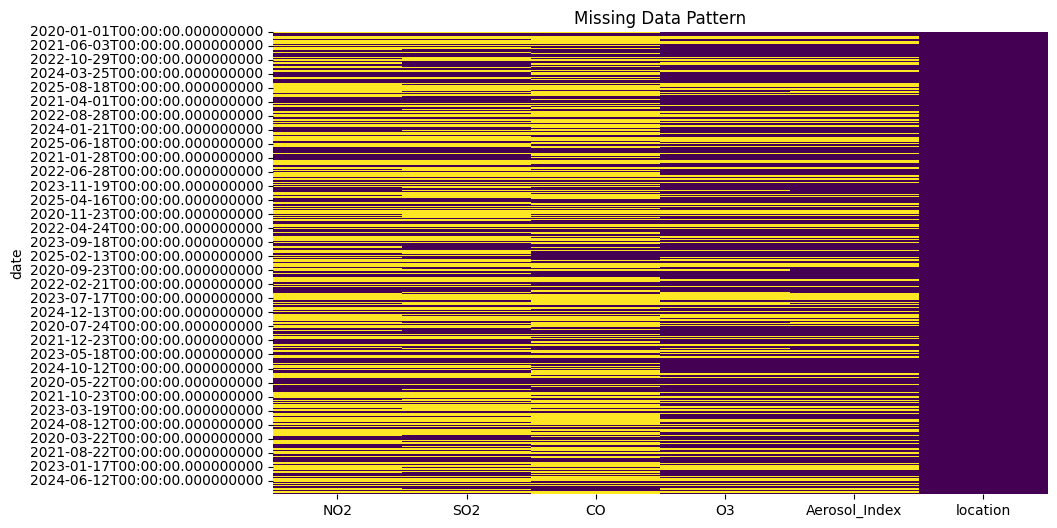

In [ ]:
# Visualize missing data patterns if needed
plt.figure(figsize=(10, 6))
sns.heatmap(s5p_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Pattern")
plt.show()

In [30]:
# Define pollutant columns to fill
pollutant_cols = ['NO2', 'SO2', 'CO', 'O3', 'Aerosol_Index']

In [33]:
# Convert pollutant columns to numeric, coercing errors to NaN
for col in pollutant_cols:
    s5p_df[col] = pd.to_numeric(s5p_df[col], errors='coerce')

In [34]:
print("\n--- Filling missing values using linear interpolation within each location group ---")

# --- Use transform instead of apply ---
# transform applies the function to each group and returns a Series/DataFrame
# with the same index as the original DataFrame, avoiding index mismatches.
s5p_filled_df = s5p_df.copy() # Work on a copy
s5p_filled_df[pollutant_cols] = s5p_filled_df.groupby('location')[pollutant_cols].transform(
    lambda group: group.interpolate(method='linear', limit_direction='both', axis=0)
)
# --- End change ---


--- Filling missing values using linear interpolation within each location group ---


In [35]:
# Verify missing values after filling
print("\n--- Missing Value Counts (After Filling) ---")
print(s5p_filled_df.isnull().sum())


--- Missing Value Counts (After Filling) ---
NO2              0
SO2              0
CO               0
O3               0
Aerosol_Index    0
location         0
dtype: int64


In [37]:
# Check if any NaNs remain (might happen if a location has ALL NaNs for a column)
if s5p_filled_df[pollutant_cols].isnull().any().any():
    print("\nWarning: Some NaNs remain after interpolation.")
    print("This might occur if an entire location group had missing data.")
    # Fill remaining NaNs with 0 or a global mean/median if appropriate
    s5p_filled_df[pollutant_cols] = s5p_filled_df[pollutant_cols].fillna(0)

In [38]:
print("\n--- First 5 rows of filled data ---")
print(s5p_filled_df.head())


--- First 5 rows of filled data ---
                 NO2       SO2        CO        O3  Aerosol_Index  \
date                                                                
2020-01-01  0.000191 -0.000433  0.048550  0.164568      -1.098919   
2020-01-02  0.000191 -0.000433  0.048550  0.164568      -1.098919   
2020-01-03  0.000143  0.000546  0.041712  0.139937      -1.405038   
2020-01-04  0.000143 -0.000315  0.044633  0.137429      -1.210190   
2020-01-05  0.000143 -0.000531  0.045669  0.128115      -0.864201   

                      location  
date                            
2020-01-01  Anand Vihar, Delhi  
2020-01-02  Anand Vihar, Delhi  
2020-01-03  Anand Vihar, Delhi  
2020-01-04  Anand Vihar, Delhi  
2020-01-05  Anand Vihar, Delhi  


In [39]:
print(f"\n--- Saving processed data to: {processed_data_path} ---")


--- Saving processed data to: ../data/processed/S5P_NRTI_Filled.csv ---


In [40]:
os.makedirs(os.path.dirname(processed_data_path), exist_ok=True)

try:
    s5p_filled_df.to_csv(processed_data_path, index=False)
    print("Processed data saved successfully.")
except Exception as e:
    print(f"Error saving processed data: {e}")

Processed data saved successfully.


In [41]:
units = { # Approximate units for labels
    'NO2': 'mol/m²',
    'SO2': 'mol/m²',
    'CO': 'mol/m²',
    'O3': 'mol/m²',
    'Aerosol_Index': 'Unitless Index'
}

In [42]:
print("\n--- Plotting Value Distributions for Each Pollutant ---")


--- Plotting Value Distributions for Each Pollutant ---


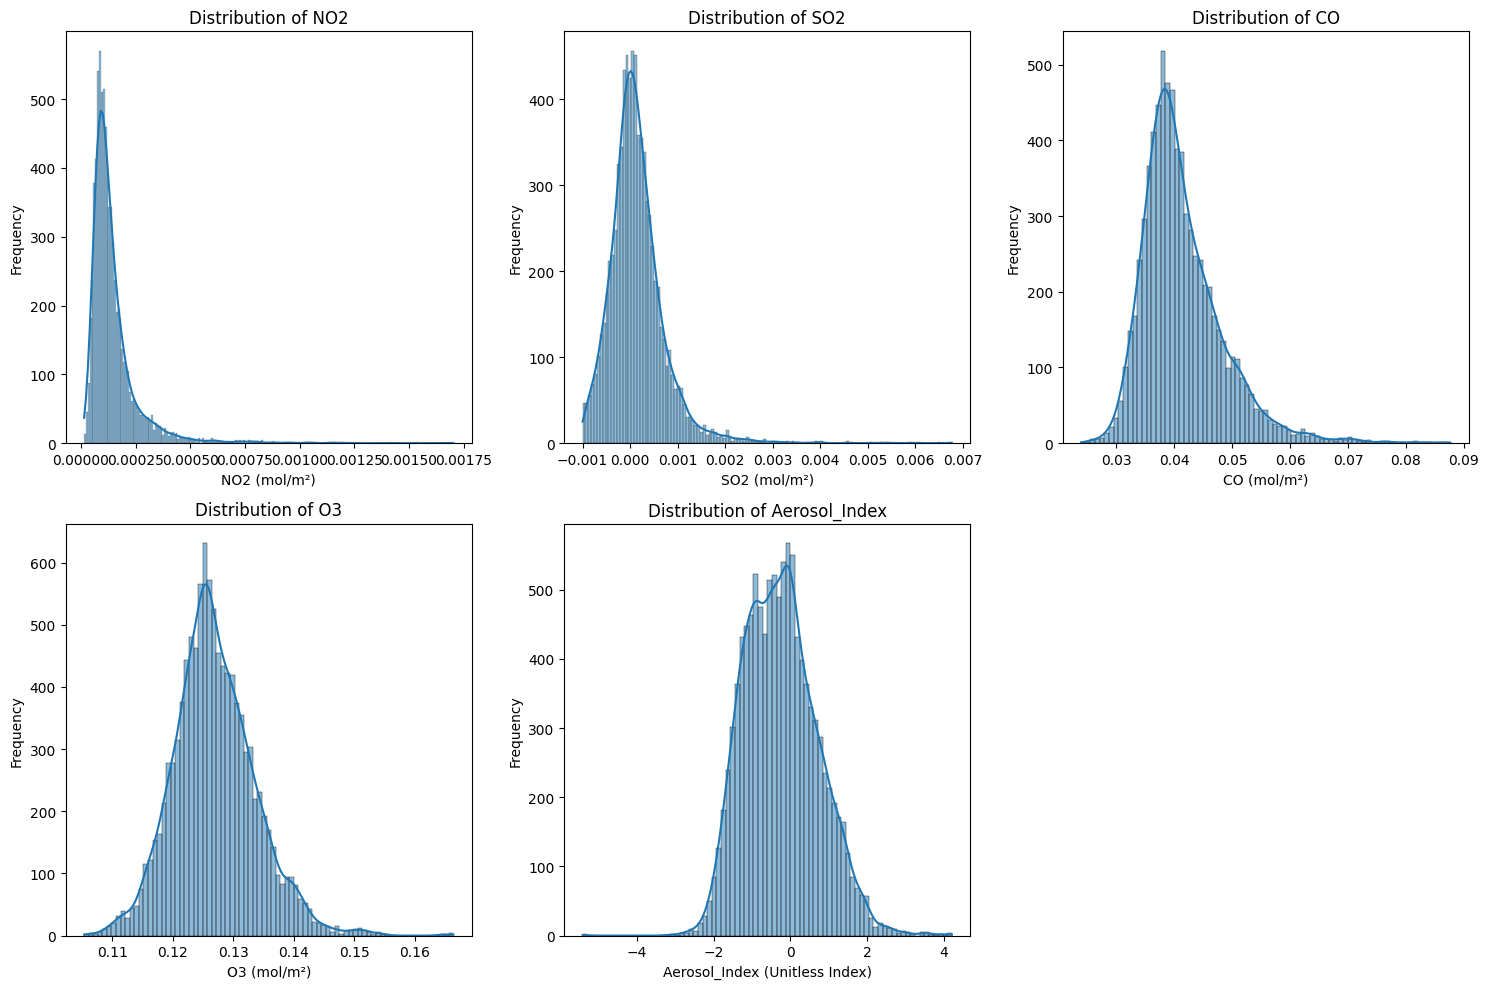

In [45]:
# Determine grid size for subplots (e.g., 2 rows, 3 columns)
n_cols = 3
n_rows = (len(pollutant_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() # Flatten the axes array for easy iteration

for i, col in enumerate(pollutant_cols):
    ax = axes[i]
    if col in s5p_df.columns and pd.api.types.is_numeric_dtype(s5p_df[col]):
        sns.histplot(s5p_df[col].dropna(), kde=True, ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(f'{col} ({units.get(col, "")})')
        ax.set_ylabel('Frequency')
    else:
        ax.set_title(f'{col} - Not Plotted (Non-numeric or Missing)')
        ax.axis('off') # Hide axis if column is not plotted

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [46]:
print("\n--- Summary Statistics for Pollutants ---")
print(s5p_df[pollutant_cols].describe())


--- Summary Statistics for Pollutants ---
               NO2          SO2           CO            O3  Aerosol_Index
count  7656.000000  7708.000000  7449.000000  10806.000000   10994.000000
mean      0.000146     0.000145     0.041423      0.126898      -0.247853
std       0.000114     0.000588     0.007013      0.006808       0.964272
min       0.000015    -0.000998     0.023917      0.105325      -5.423089
25%       0.000083    -0.000198     0.036805      0.122542      -0.970623
50%       0.000115     0.000074     0.039930      0.126296      -0.299222
75%       0.000168     0.000398     0.044738      0.130914       0.372394
max       0.001703     0.006777     0.087687      0.166354       4.218647
